In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import zlib
import warnings

warnings.filterwarnings("ignore")
sns.set_style("whitegrid")

BASE_DIR = Path("..")
INTERMEDIATE_DIR = BASE_DIR / "data" / "intermediate"

print("=" * 80)
print("COMPREHENSIVE INTERMEDIATE DATASET ANALYSIS")
print("=" * 80)

COMPREHENSIVE INTERMEDIATE DATASET ANALYSIS


In [5]:
print("\nLoading intermediate parquet files...")

parquet_files = sorted(INTERMEDIATE_DIR.glob("data_rank*.parquet"))
print(f"   Found {len(parquet_files)} files")

dfs = []
for pf in parquet_files:
    df = pd.read_parquet(pf)
    dfs.append(df)
    print(f"   {pf.name}: {len(df)} rows")

df_full = pd.concat(dfs, ignore_index=True)

print(f"\nTotal loaded: {len(df_full)} rows")
print(f"Columns: {list(df_full.columns)}")
print(f"Memory usage: {df_full.memory_usage(deep=True).sum() / (1024**2):.1f} MB")

print("\nDataset Info:")
print(f"Unique samples: {df_full['sample_id'].nunique()}")
print(f"Unique params: {df_full['param_id'].nunique()}")
print(f"Image shape (first): {df_full['image_shape'].iloc[0]}")


Loading intermediate parquet files...
   Found 8 files
   data_rank0000.parquet: 780 rows
   data_rank0001.parquet: 780 rows
   data_rank0002.parquet: 780 rows
   data_rank0003.parquet: 780 rows
   data_rank0004.parquet: 720 rows
   data_rank0005.parquet: 720 rows
   data_rank0006.parquet: 720 rows
   data_rank0007.parquet: 720 rows

Total loaded: 6000 rows
Columns: ['sample_id', 'param_id', 'image_compressed', 'image_shape', 'input_params', 'microstructure_outputs', 'performance_outputs']
Memory usage: 1125.1 MB

Dataset Info:
Unique samples: 100
Unique params: 60
Image shape (first): [128 128 128]


In [6]:
INPUT_FEATURES = [
    "SEI_kinetic_rate",
    "Electrolyte_diffusivity",
    "Initial_conc_electrolyte",
    "Separator_porosity",
    "Separator_Bruggeman_electrolyte",
    "Separator_Bruggeman",
    "Positive_particle_radius",
    "Negative_particle_radius",
    "Positive_electrode_thickness",
    "Negative_electrode_thickness",
]

MICROSTRUCTURE_FEATURES = [
    "D_eff",
    "porosity_measured",
    "tau_factor",
    "bruggeman_derived",
]

PERFORMANCE_FEATURES = [
    "eol_cycle_measured",
    "initial_capacity_Ah",
    "final_capacity_Ah",
    "capacity_retention_percent",
    "total_cycles",
]

input_arrays = np.array(df_full["input_params"].tolist())
df_inputs = pd.DataFrame(input_arrays, columns=INPUT_FEATURES)

micro_arrays = np.array(df_full["microstructure_outputs"].tolist())
df_micro = pd.DataFrame(micro_arrays, columns=MICROSTRUCTURE_FEATURES)

perf_arrays = np.array(df_full["performance_outputs"].tolist())
df_perf = pd.DataFrame(perf_arrays, columns=PERFORMANCE_FEATURES)

df_expanded = pd.concat(
    [
        df_full[["sample_id", "param_id"]].reset_index(drop=True),
        df_inputs,
        df_micro,
        df_perf,
    ],
    axis=1,
)

print(f"Expanded dataset shape: {df_expanded.shape}")
print(f"Total columns: {len(df_expanded.columns)}")

Expanded dataset shape: (6000, 21)
Total columns: 21


In [7]:
input_stats = df_inputs.describe().T
input_stats["missing"] = df_inputs.isnull().sum()
input_stats["missing_pct"] = (input_stats["missing"] / len(df_inputs) * 100).round(2)

cols = [
    "count",
    "mean",
    "std",
    "min",
    "25%",
    "50%",
    "75%",
    "max",
    "missing",
    "missing_pct",
]
input_stats = input_stats[cols]

print(input_stats.to_string())

missing_features = input_stats[input_stats["missing"] > 0]
constant_features = input_stats[input_stats["std"] == 0]

print("\nMissing features:")
print(missing_features[["missing", "missing_pct"]] if len(missing_features) else "None")

print("\nConstant features:")
print(constant_features[["mean"]] if len(constant_features) else "None")

                                  count          mean           std           min           25%           50%           75%           max  missing  missing_pct
SEI_kinetic_rate                 6000.0  1.449557e-13  2.271902e-13  1.080000e-15  5.907500e-15  3.090000e-14  1.735000e-13  9.230000e-13        0          0.0
Electrolyte_diffusivity          6000.0  3.001000e-10  5.789803e-11  2.000000e-10  2.515000e-10  3.010000e-10  3.497500e-10  3.980000e-10        0          0.0
Initial_conc_electrolyte         6000.0  1.000000e+03  0.000000e+00  1.000000e+03  1.000000e+03  1.000000e+03  1.000000e+03  1.000000e+03        0          0.0
Separator_porosity               6000.0  5.870974e-01  2.892336e-02  5.380924e-01  5.628673e-01  5.867180e-01  6.123321e-01  6.363797e-01        0          0.0
Separator_Bruggeman_electrolyte  6000.0  2.667379e+00  1.542638e-01  2.404702e+00  2.538698e+00  2.669024e+00  2.801685e+00  2.928699e+00        0          0.0
Separator_Bruggeman              6000.0 

In [8]:
micro_stats = df_micro.describe().T
micro_stats["missing"] = df_micro.isnull().sum()
micro_stats["missing_pct"] = (micro_stats["missing"] / len(df_micro) * 100).round(2)
micro_stats = micro_stats[cols]

print(micro_stats.to_string())

print("\nMicrostructure correlation matrix:")
print(df_micro.corr().to_string())

                    count       mean         std       min       25%       50%       75%         max  missing  missing_pct
D_eff              6000.0   0.210705    0.183321  0.000154  0.041231  0.164922  0.348979    0.633595        0          0.0
porosity_measured  6000.0   0.487339    0.179578  0.152606  0.333235  0.494411  0.651169    0.815443        0          0.0
tau_factor         6000.0  27.388088  114.138089  1.179202  1.801661  3.085141  7.657228  989.615723        0          0.0
bruggeman_derived  6000.0   2.716168    0.691878  1.565469  2.280472  2.598797  3.009289    5.707782        0          0.0

Microstructure correlation matrix:
                      D_eff  porosity_measured  tau_factor  bruggeman_derived
D_eff              1.000000           0.940955   -0.252550          -0.598941
porosity_measured  0.940955           1.000000   -0.357977          -0.523963
tau_factor        -0.252550          -0.357977    1.000000           0.557173
bruggeman_derived -0.598941          

In [9]:
perf_stats = df_perf.describe().T
perf_stats["missing"] = df_perf.isnull().sum()
perf_stats["missing_pct"] = (perf_stats["missing"] / len(df_perf) * 100).round(2)
perf_stats = perf_stats[cols]

print(perf_stats.to_string())

retention = df_perf["capacity_retention_percent"].dropna()
cycles = df_perf["total_cycles"].dropna()
eol_cycles = df_perf["eol_cycle_measured"].dropna()

print("\nRetention summary:")
print(retention.describe())

print("\nCycle summary:")
print(f"Mean total cycles: {cycles.mean():.1f}")
print(f"Mean EOL cycles: {eol_cycles.mean():.1f}")

                             count       mean         std       min        25%        50%        75%         max  missing  missing_pct
eol_cycle_measured          3330.0  16.548649   47.318014  1.000000   1.000000   1.000000   9.000000  458.000000     2670        44.50
initial_capacity_Ah         5266.0   4.453248    1.878102  0.011485   2.975208   4.456347   6.029761    8.428087      734        12.23
final_capacity_Ah           5266.0   3.395651    1.471263  0.000032   2.212541   3.384783   4.659725    8.204581      734        12.23
capacity_retention_percent  5266.0  77.177955   19.378151  0.003306  73.244704  75.242661  76.466833  876.455893      734        12.23
total_cycles                6000.0  85.942333  119.246367  0.000000  18.000000  37.000000  88.000000  500.000000        0         0.00

Retention summary:
count    5266.000000
mean       77.177955
std        19.378151
min         0.003306
25%        73.244704
50%        75.242661
75%        76.466833
max       876.455893
Na

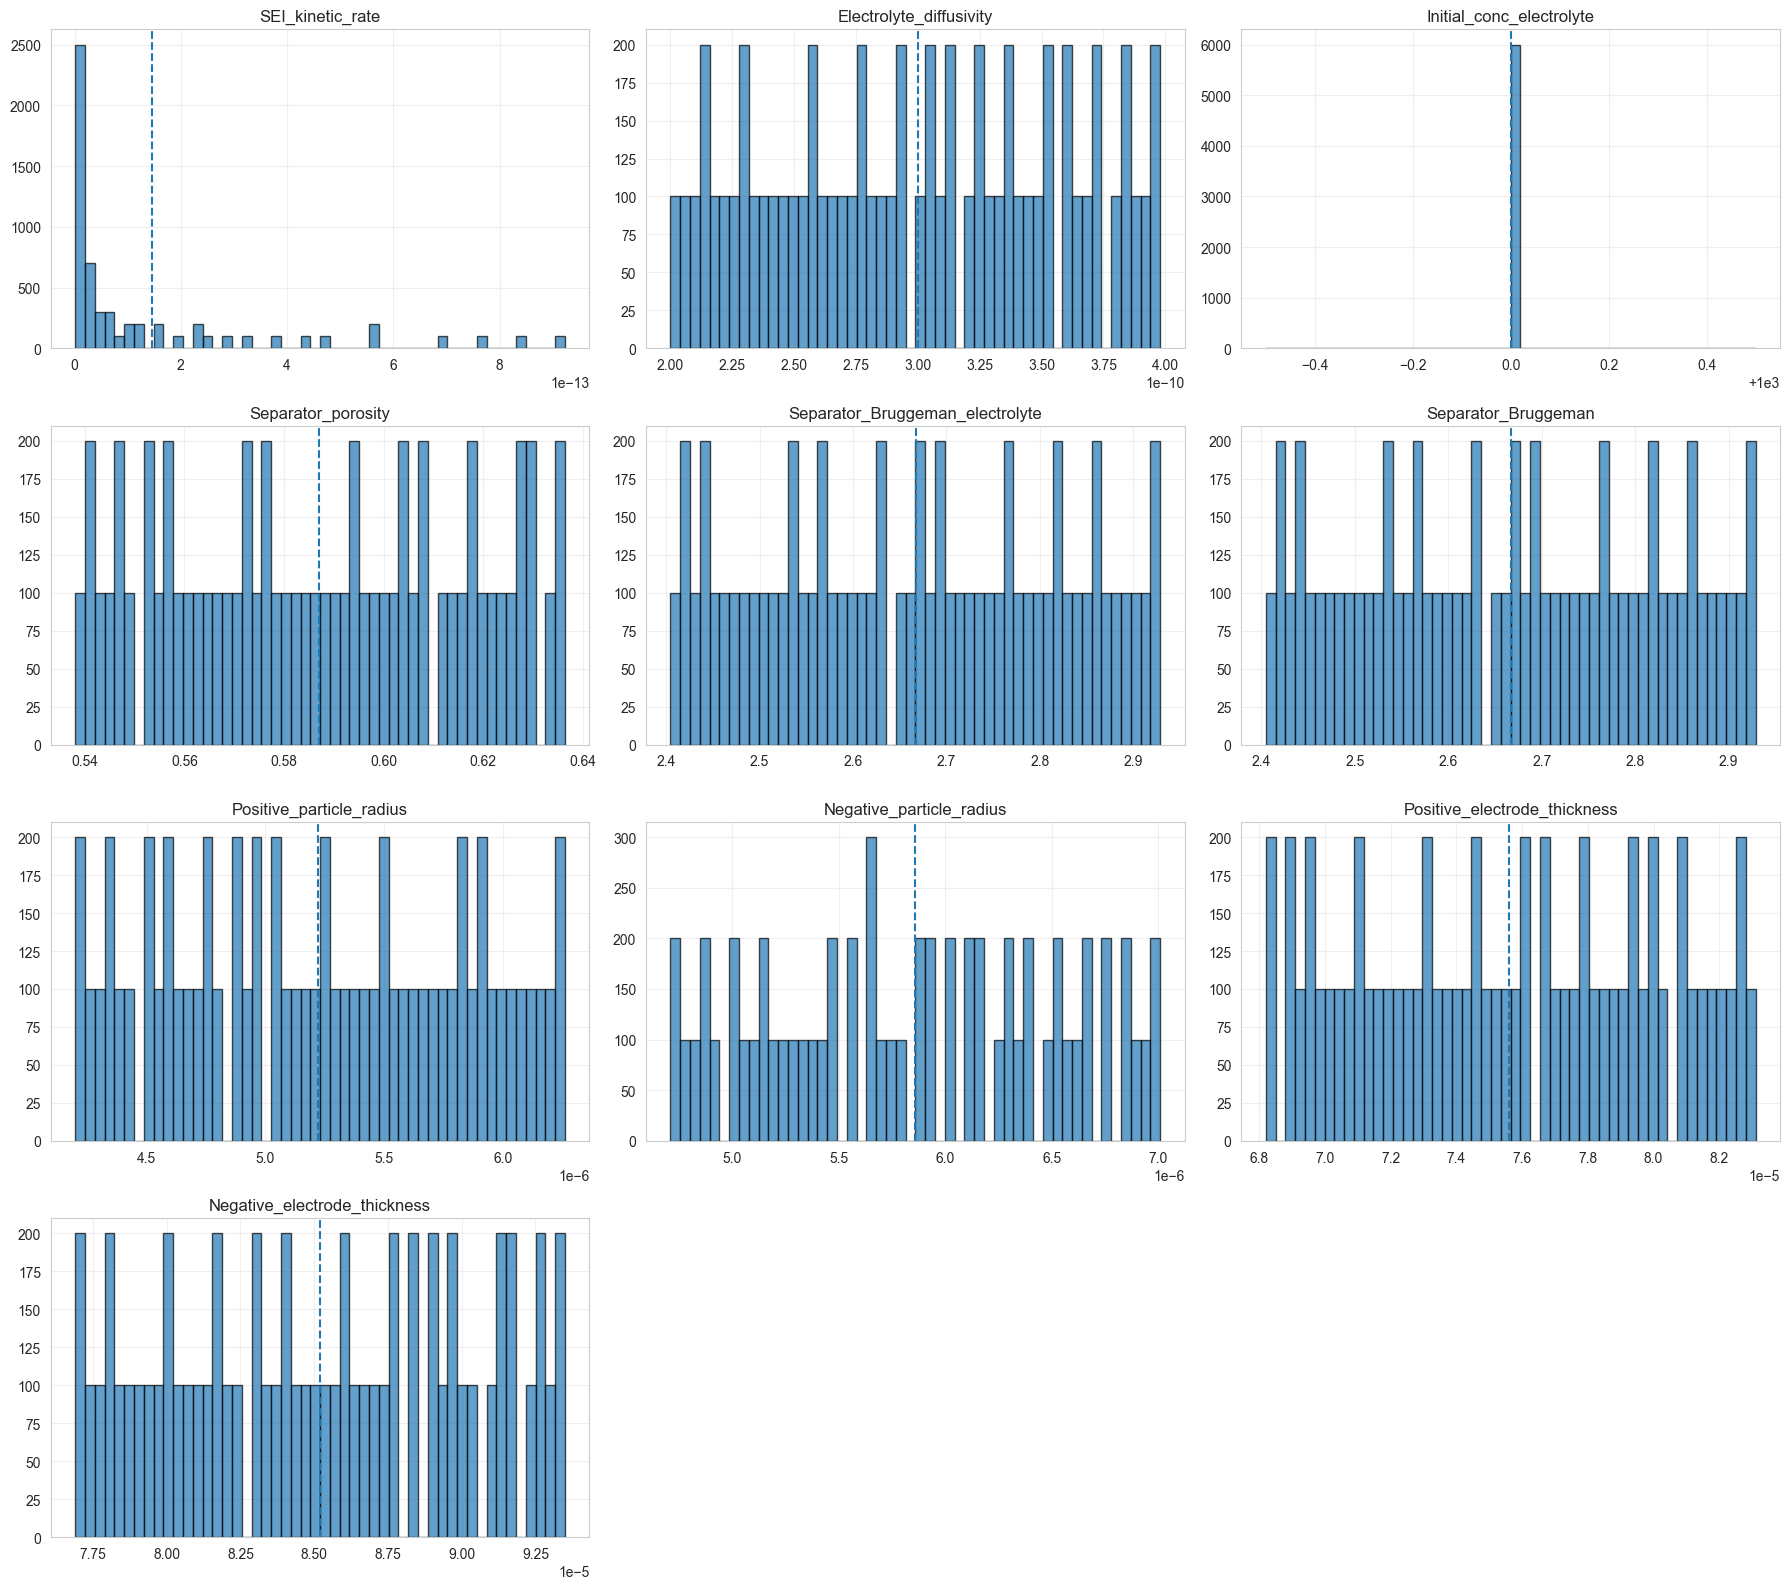

In [10]:
n_features = len(INPUT_FEATURES)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows))
axes = axes.flatten()

for idx, feat in enumerate(INPUT_FEATURES):
    data = df_inputs[feat].dropna()
    ax = axes[idx]
    ax.hist(data, bins=50, alpha=0.7, edgecolor="black")
    ax.axvline(data.mean(), linestyle="--")
    ax.set_title(feat)
    ax.grid(True, alpha=0.3)

for idx in range(n_features, len(axes)):
    axes[idx].axis("off")

plt.tight_layout()
plt.show()

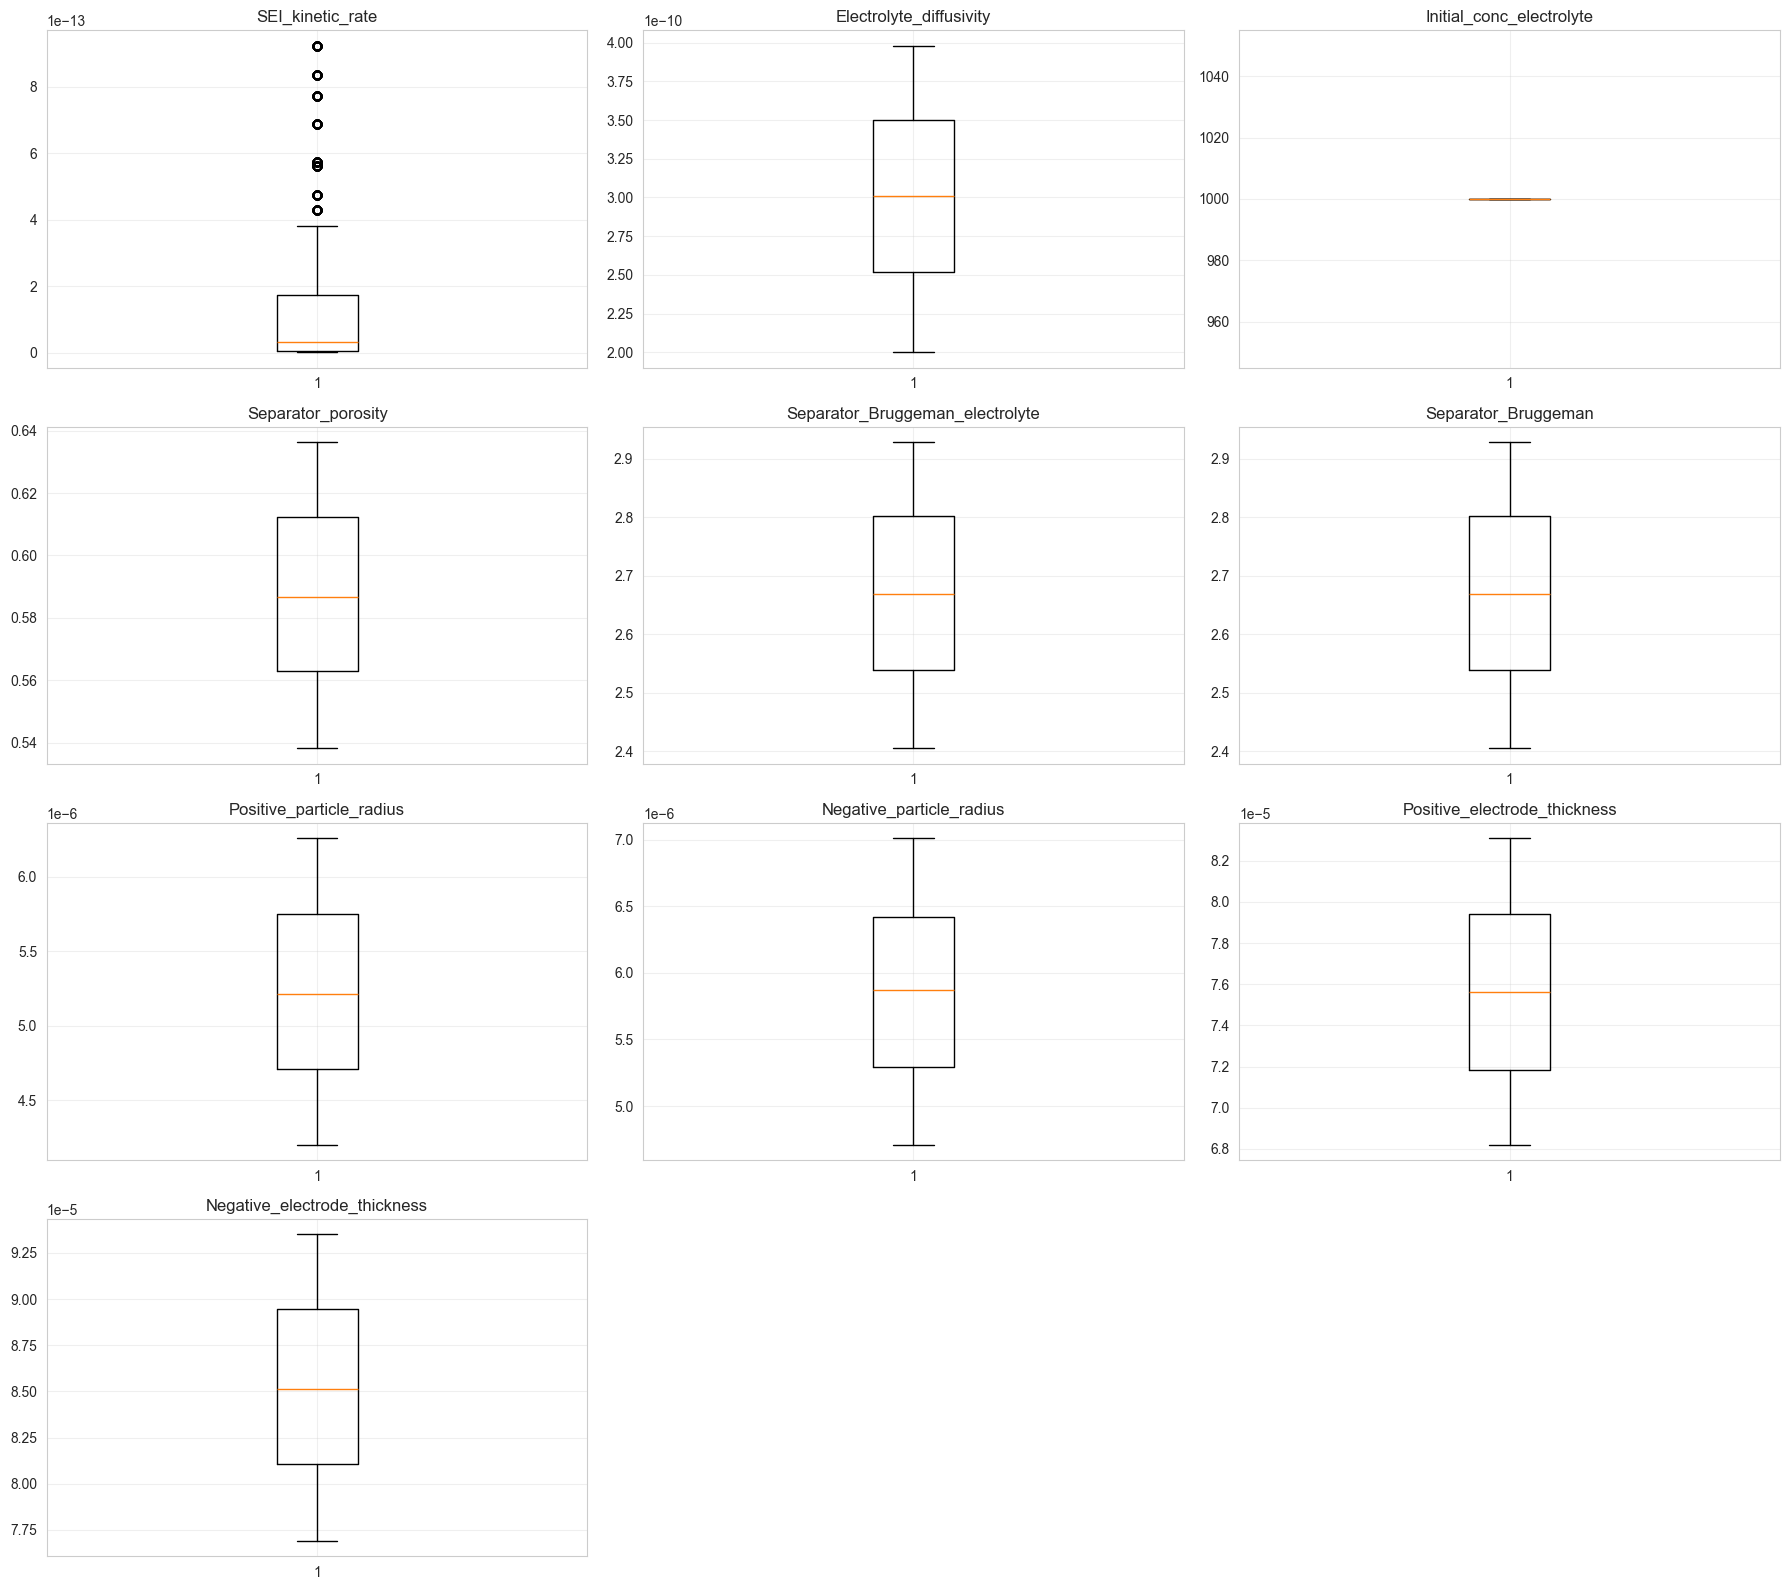

In [11]:
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows))
axes = axes.flatten()

for idx, feat in enumerate(INPUT_FEATURES):
    data = df_inputs[feat].dropna()
    ax = axes[idx]
    ax.boxplot(data, vert=True)
    ax.set_title(feat)
    ax.grid(True, alpha=0.3)

for idx in range(n_features, len(axes)):
    axes[idx].axis("off")

plt.tight_layout()
plt.show()

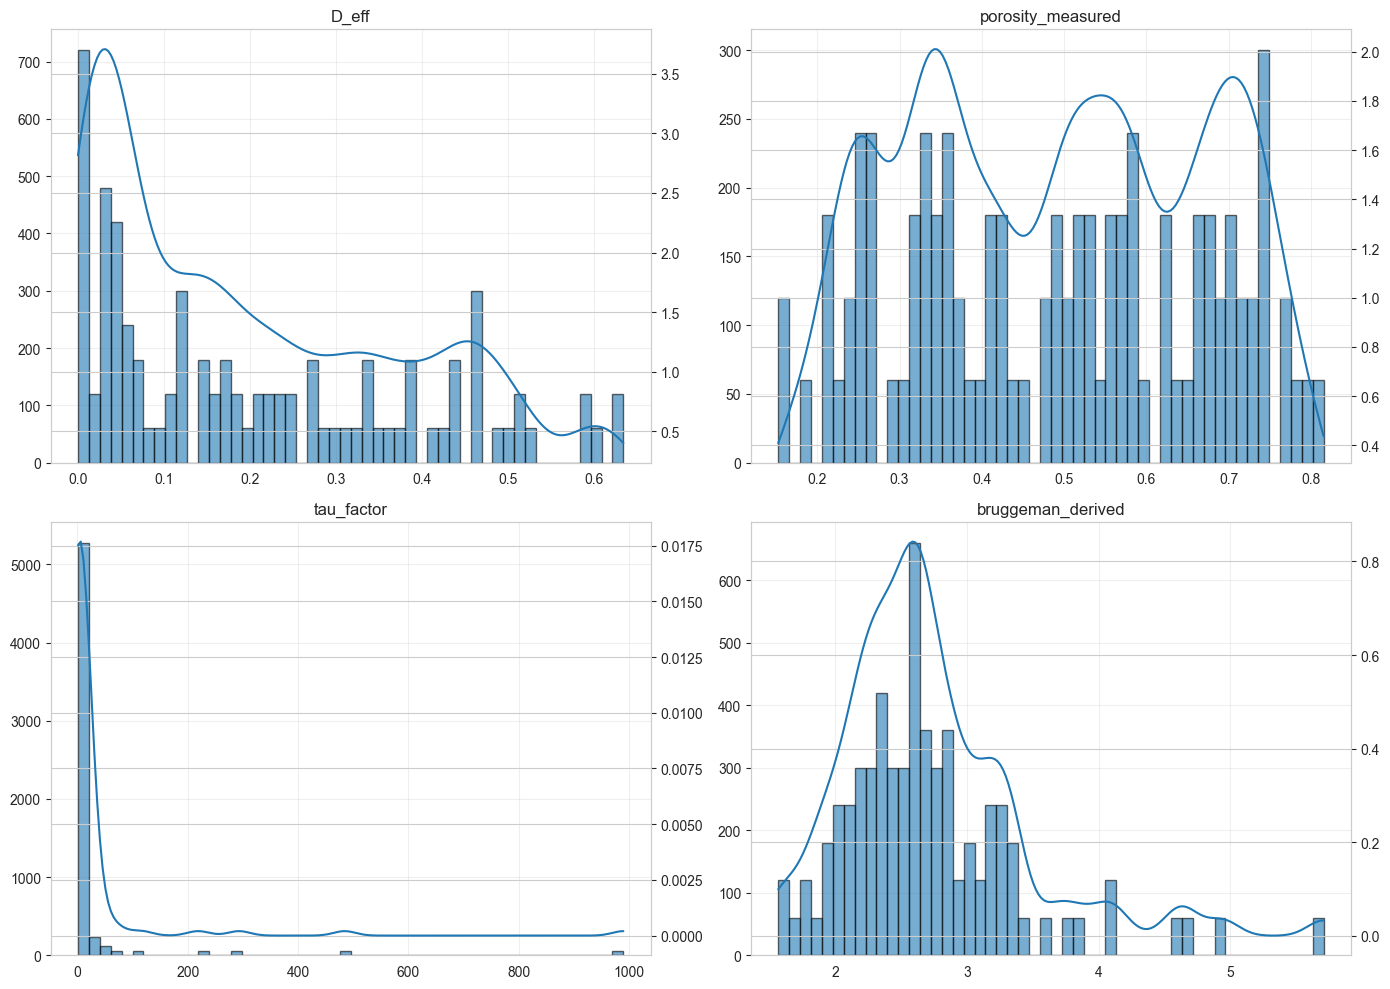

In [12]:
from scipy import stats

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, feat in enumerate(MICROSTRUCTURE_FEATURES):
    data = df_micro[feat].dropna()
    ax = axes[idx]
    ax.hist(data, bins=50, alpha=0.6, edgecolor="black")

    density = stats.gaussian_kde(data)
    xs = np.linspace(data.min(), data.max(), 200)
    ax2 = ax.twinx()
    ax2.plot(xs, density(xs))

    ax.set_title(feat)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

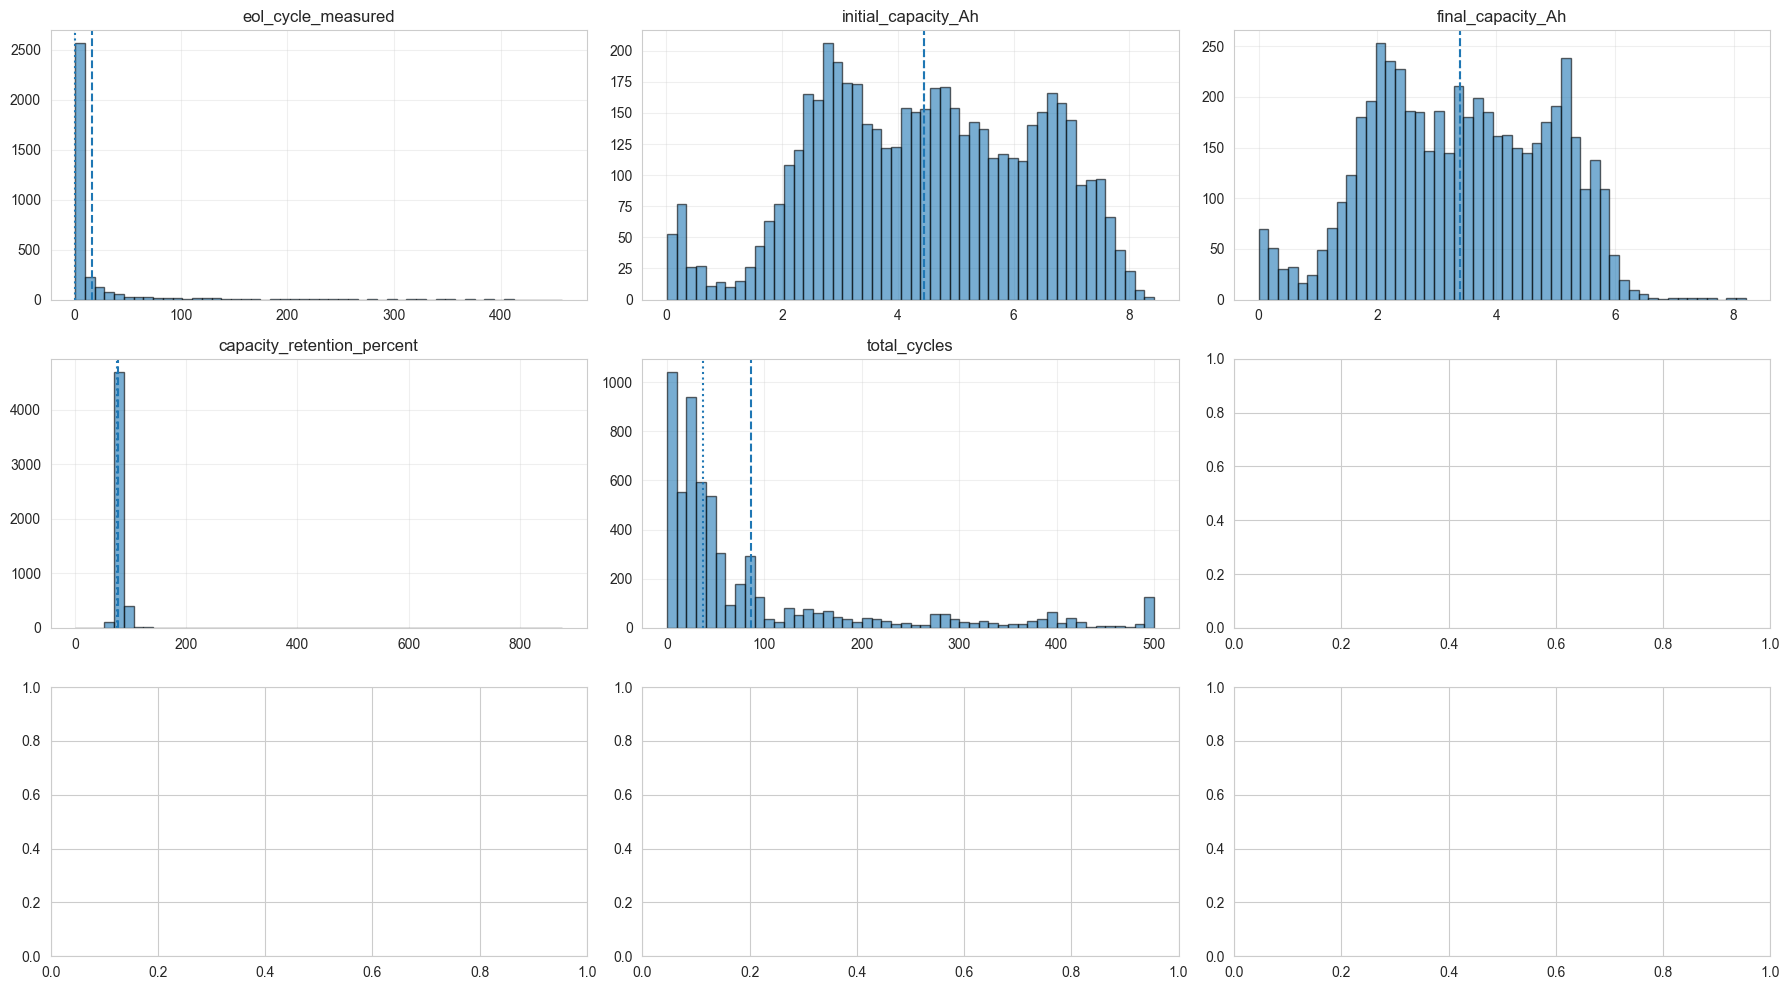

In [13]:
fig, axes = plt.subplots(3, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, feat in enumerate(PERFORMANCE_FEATURES):
    ax = axes[idx]
    data = df_perf[feat].dropna()
    if len(data) == 0:
        ax.set_title(f"{feat} (no data)")
        continue
    ax.hist(data, bins=50, alpha=0.6, edgecolor="black")
    ax.axvline(data.mean(), linestyle="--")
    ax.axvline(data.median(), linestyle=":")
    ax.set_title(feat)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [14]:
summary = {
    "dataset": {
        "total_rows": len(df_expanded),
        "unique_samples": int(df_expanded["sample_id"].nunique()),
        "unique_params": int(df_expanded["param_id"].nunique()),
    }
}

summary_file = BASE_DIR / "data" / "intermediate_analysis_summary.json"
with open(summary_file, "w") as f:
    json.dump(summary, f, indent=2)

sample_file = BASE_DIR / "data" / "intermediate_sample.csv"
df_expanded.head(100).to_csv(sample_file, index=False)

print("Analysis complete.")

Analysis complete.
